In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import warnings
import numpy as np
warnings.filterwarnings('ignore')


In [2]:
#df=pd.read_csv('data/8countries/top200_processed2.csv')
df=pd.read_csv('data/top200_9countries_processed.csv')
df.head(2)

,Unnamed: 0,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,rank,date,region,trend,streams,year,month,top200_count,trend_rank_score,stream_bins
0,0,76,0.620,0.936,7,-4.593,1,0.0308,0.0261,0.000,...,199,2017-01-01,United States,NEW_ENTRY,143813.0,2017,1,1,0.01,1
1,1,0,0.725,0.853,2,-7.842,1,0.0353,0.0348,0.127,...,193,2017-01-01,United States,NEW_ENTRY,144843.0,2017,1,1,0.04,1


In [3]:
df=df.drop(['Unnamed: 0','time_signature','title','trend','date','streams'],axis=1)

In [4]:
#encoding region and years
regions=list(df['region'].unique())
years=list(df['year'].unique())
df['enc_region']=df['region'].apply(lambda x:regions.index(x))
df['enc_year']=df['year'].apply(lambda x:years.index(x))


In [5]:
df=df.drop(['region','year'],axis=1)

In [6]:
y = df['stream_bins']
X = df.drop('stream_bins', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=0.2)

In [44]:
len(X)

58407

In [42]:
len(X_train)

46725

In [43]:
len(X_test)

11682

In [7]:
scaler = StandardScaler()
# Scale train and test features
scaled_X=scaler.fit_transform(X)
scaled_train = scaler.fit_transform(X_train)
scaled_test = scaler.fit_transform(X_test)
scaled_train_df = pd.DataFrame(scaled_train, columns=X.columns)
scaled_train_df.head()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,rank,month,top200_count,trend_rank_score,enc_region,enc_year
0,-0.317119,0.287068,0.355382,0.753186,-0.019221,0.895642,-0.681441,-0.843922,-0.169105,-0.502691,0.738320,0.978734,-0.316170,0.725143,0.984164,1.153201,1.206157,1.131677,0.621995
1,0.109340,0.165838,-0.231909,-0.344422,-0.332413,0.895642,0.854639,0.960837,-0.169105,-0.322704,-1.000373,-1.611655,-0.785781,-0.042074,-0.476616,-0.441743,-0.407225,-1.532335,-0.795008
2,0.574567,-1.625674,1.148226,0.753186,0.642341,0.895642,-0.714441,-0.648356,-0.169105,1.019697,-0.622594,1.692174,-0.349139,0.497819,0.984164,-0.450137,-0.417744,-1.151762,0.621995
3,1.233638,-0.622158,-1.206813,-0.070020,0.254255,-1.116517,-0.846442,0.365287,-0.169105,-0.679678,-0.895687,-1.504122,1.855578,-0.752461,0.984164,0.414491,0.127240,-0.771189,1.330497
4,-0.510963,-0.319083,1.729645,-0.070020,0.575390,0.895642,-0.831513,-0.905891,-0.169088,-0.285207,-0.900239,-0.026958,0.063863,0.355742,0.107696,-0.416559,-0.388475,1.131677,-1.503509


In [8]:
from yellowbrick.classifier import ROCAUC

def ROC_curve_plot(model, X_train, y_train, X_test, y_test):
    try:
        plot = ROCAUC(model)                                   
        plot.fit(X_train, y_train)
        plot.score(X_test, y_test)
        plot.show()
    except Exception as e:
        print(e)
    return plot

DUMMY CLASSIFIER

In [40]:
#dummy classifier - baseline
from sklearn.dummy import DummyClassifier
dummy_model = DummyClassifier(strategy= "most_frequent")
dummy_model.fit(X_train, y_train)
y_pred = dummy_model.predict(y_test)

print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred)) 


[[   0    0    0 2995]
 [   0    0    0 2904]
 [   0    0    0 2916]
 [   0    0    0 2867]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      2995
           2       0.00      0.00      0.00      2904
           3       0.00      0.00      0.00      2916
           4       0.25      1.00      0.39      2867

    accuracy                           0.25     11682
   macro avg       0.06      0.25      0.10     11682
weighted avg       0.06      0.25      0.10     11682



In [41]:
print('Weighted F1 score: ',metrics.f1_score(y_test,y_pred,average='weighted'))
print('Weighted precision score: ',metrics.precision_score(y_test,y_pred,average='weighted'))
print('Weighted recall score: ',metrics.recall_score(y_test,y_pred,average='weighted'))

Weighted F1 score:  0.09672417536549384
Weighted precision score:  0.060231125979822366
Weighted recall score:  0.24542030474233864


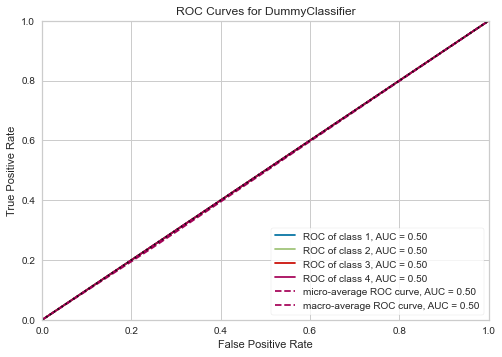

In [46]:
try:
    ROC_curve_plot(dummy_model,X_train,y_train,X_test,y_test)
except:
    print()

LOGISTIC REGRESSION

In [10]:
#Logistic Regression - baseline 2
logistic_model = LogisticRegression(multi_class="ovr")
logistic_model.fit(scaled_train, y_train)
y_pred = logistic_model.predict(scaled_test)

print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred)) 
print('Weighted F1 score:',metrics.f1_score(y_test,y_pred,average='weighted'))

[[2344  223  328  100]
 [1100  807  718  279]
 [ 420  604 1155  737]
 [  97  184  389 2197]]
              precision    recall  f1-score   support

           1       0.59      0.78      0.67      2995
           2       0.44      0.28      0.34      2904
           3       0.45      0.40      0.42      2916
           4       0.66      0.77      0.71      2867

    accuracy                           0.56     11682
   macro avg       0.54      0.56      0.54     11682
weighted avg       0.54      0.56      0.54     11682

Weighted F1 score: 0.5369725482003868


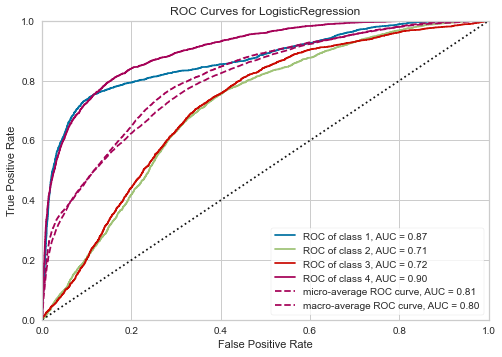

In [12]:
try:
    ROC_curve_plot(logistic_model,scaled_train,y_train,scaled_test,y_test)
except:
    print()

DECISION TREE

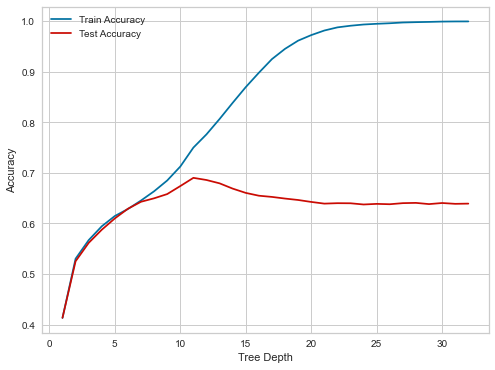

In [43]:
#To determine optimal tree depth
tree_depths = np.linspace(1,32,32,endpoint=True)
train_res=[]
test_res=[]
for d in tree_depths:
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=d, random_state=42)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    acc = metrics.accuracy_score(y_train, train_pred)
    train_res.append(acc)
    y_pred = dt.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    test_res.append(acc)
plt.figure(figsize=(8,6))
plt.plot(tree_depths, train_res, 'b', label='Train Accuracy')
plt.plot(tree_depths, test_res, 'r', label='Test Accuracy')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

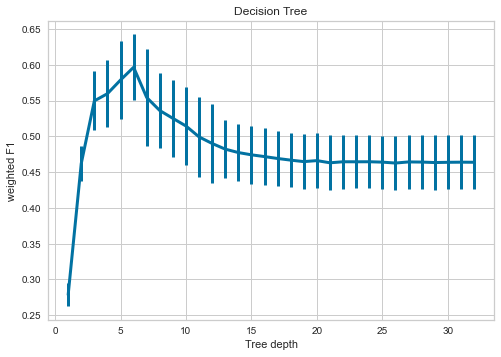

In [16]:
#To determine optimal tree depth
tree_depths = np.linspace(1,32,32,endpoint=True)
mean_err=[]
std_err=[]
for d in tree_depths:
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=d, random_state=42)
    scores = cross_val_score(dt, X, y, cv=5, scoring='f1_weighted')
    mean_err.append(np.array(scores).mean())
    std_err.append(np.array(scores).std())
plt.errorbar(tree_depths,mean_err,yerr=std_err,linewidth=3)
plt.xlabel('Tree depth'); plt.ylabel('weighted F1')
plt.title('Decision Tree')
plt.show()

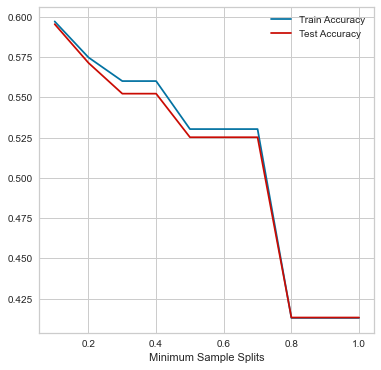

In [45]:
#To determine optimal sample splits
sample_sp = np.linspace(0.1,1.0,10, endpoint=True)
train_res = []
test_res = []
for sp in sample_sp:
    dt = DecisionTreeClassifier (criterion = 'entropy', min_samples_split = sp, random_state=42)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    acc = metrics.accuracy_score(y_train, train_pred)
    train_res.append(acc)
    y_pred = dt.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    test_res.append(acc)
plt.figure(figsize=(6,6))
plt.plot(sample_sp, train_res, 'b', label = 'Train Accuracy')
plt.plot(sample_sp, test_res, 'r',label = 'Test Accuracy')
plt.xlabel('Minimum Sample Splits')
plt.legend()
plt.show()

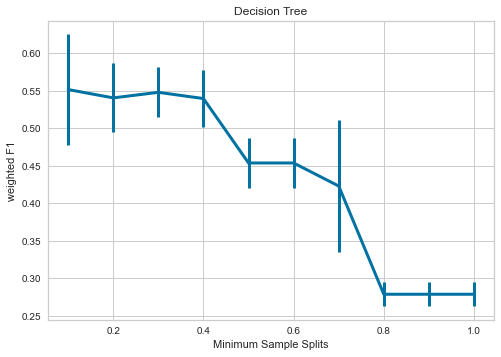

In [17]:
#To determine optimal sample splits
sample_sp = np.linspace(0.1,1.0,10, endpoint=True)
mean_err=[]
std_err=[]
for sp in sample_sp:
    dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=sp, random_state=42)
    scores = cross_val_score(dt, X, y, cv=5, scoring='f1_weighted')
    mean_err.append(np.array(scores).mean())
    std_err.append(np.array(scores).std())
plt.errorbar(sample_sp,mean_err,yerr=std_err,linewidth=3)
plt.xlabel('Minimum Sample Splits'); plt.ylabel('weighted F1')
plt.title('Decision Tree')
plt.show()

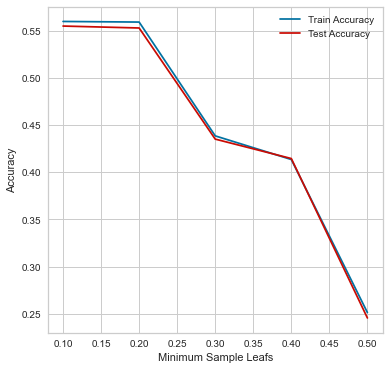

In [47]:
# to determine optimal minimum sample leafs
sp_lfs=np.linspace(0.1,0.5,5, endpoint = True)
train_res=[]
test_res=[]
for sp in sp_lfs:
    dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf = sp, random_state=42)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    acc = metrics.accuracy_score(y_train, train_pred)
    train_res.append(acc)
    y_pred = dt.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    test_res.append(acc)
plt.figure(figsize=(6,6))
plt.plot(sp_lfs, train_res, 'b', label='Train Accuracy')
plt.plot(sp_lfs, test_res, 'r', label='Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Minimum Sample Leafs')
plt.legend()
plt.show()

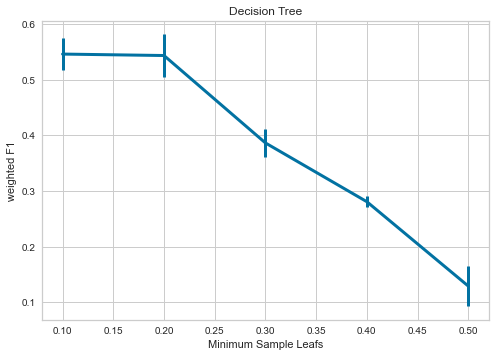

In [18]:
#To determine optimal sample leafs
sp_lfs=np.linspace(0.1,0.5,5, endpoint = True)
mean_err=[]
std_err=[]
for sp in sp_lfs:
    dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=sp, random_state=42)
    scores = cross_val_score(dt, X, y, cv=5, scoring='f1_weighted')
    mean_err.append(np.array(scores).mean())
    std_err.append(np.array(scores).std())
plt.errorbar(sp_lfs,mean_err,yerr=std_err,linewidth=3)
plt.xlabel('Minimum Sample Leafs'); plt.ylabel('weighted F1')
plt.title('Decision Tree')
plt.show()

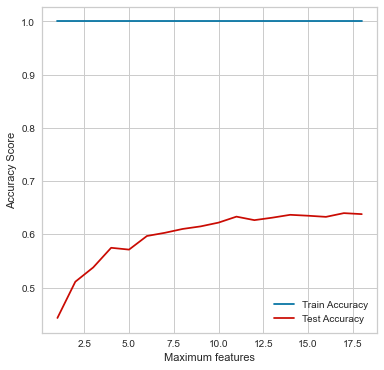

In [49]:
#To determine optimal max features
mfs = list(range(1, X_train.shape[1]))
train_res = []
test_res = []
for mf in mfs:
    dt = DecisionTreeClassifier(criterion = 'entropy', max_features = mf, random_state=42)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    acc = metrics.accuracy_score(y_train, train_pred)
    train_res.append(acc)
    y_pred = dt.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    test_res.append(acc)
plt.figure(figsize=(6,6))
plt.plot(mfs, train_res, 'b', label = 'Train Accuracy')
plt.plot(mfs, test_res, 'r', label = 'Test Accuracy')
plt.ylabel('Accuracy Score')
plt.xlabel('Maximum features')
plt.legend()
plt.show()

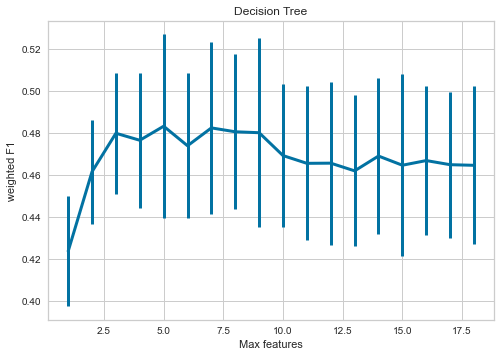

In [19]:
#To determine optimal max features
mfs = list(range(1, X_train.shape[1]))
mean_err=[]
std_err=[]
for mf in mfs:
    dt = DecisionTreeClassifier(criterion='entropy', max_features=mf, random_state=42)
    scores = cross_val_score(dt, X, y, cv=5, scoring='f1_weighted')
    mean_err.append(np.array(scores).mean())
    std_err.append(np.array(scores).std())
plt.errorbar(mfs,mean_err,yerr=std_err,linewidth=3)
plt.xlabel('Max features'); plt.ylabel('weighted F1')
plt.title('Decision Tree')
plt.show()

In [47]:
tuned_dt = DecisionTreeClassifier(criterion='entropy',max_features=11,max_depth = 6,min_samples_split = 0.1,min_samples_leaf = 0.1,random_state = 42)
tuned_dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, max_features=11,
                       min_samples_leaf=0.1, min_samples_split=0.1,
                       random_state=42)

In [48]:
y_pred = tuned_dt.predict(X_test)
print('Weighted F1 score:',metrics.f1_score(y_test, y_pred,average='weighted'))
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

Weighted F1 score: 0.5461180294753487
[[2072  385  246  292]
 [ 722  969  877  336]
 [ 263  617 1321  715]
 [  79   94  569 2125]]
              precision    recall  f1-score   support

           1       0.66      0.69      0.68      2995
           2       0.47      0.33      0.39      2904
           3       0.44      0.45      0.45      2916
           4       0.61      0.74      0.67      2867

    accuracy                           0.56     11682
   macro avg       0.55      0.55      0.55     11682
weighted avg       0.55      0.56      0.55     11682



In [32]:
def feature_importance_plot(model):
    n = X_train.shape[1]
    plt.figure(figsize=(6,6))
    plt.barh(range(n), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')


In [49]:
tuned_dt.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.58237353, 0.        ,
       0.01146249, 0.        , 0.        , 0.40616398])

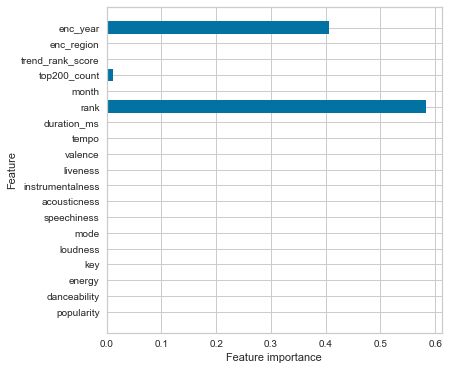

In [50]:
feature_importance_plot(tuned_dt)

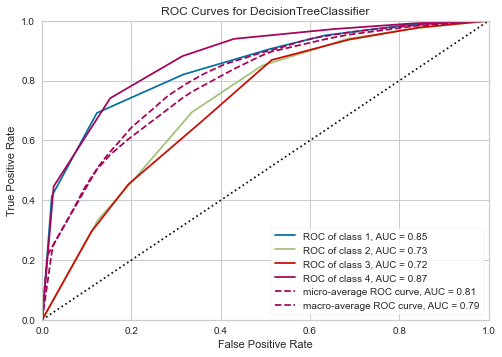

In [51]:
try:
    ROC_curve_plot(tuned_dt,X_train,y_train,X_test,y_test)
except:
    print()

K NEAREST NEIGHBOURS

In [53]:
# K Nearest Neighbours
untuned_KNN = KNeighborsClassifier()
untuned_KNN.fit(scaled_train, y_train)
y_pred = untuned_KNN.predict(scaled_test)

In [54]:
print('Weighted F1 score:',metrics.f1_score(y_test, y_pred,average='weighted'))
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

Weighted F1 score: 0.5086854721470068
[[2001  629  311   54]
 [ 782 1242  722  158]
 [ 473 1035 1054  354]
 [ 151  464  641 1611]]
              precision    recall  f1-score   support

           1       0.59      0.67      0.63      2995
           2       0.37      0.43      0.40      2904
           3       0.39      0.36      0.37      2916
           4       0.74      0.56      0.64      2867

    accuracy                           0.51     11682
   macro avg       0.52      0.50      0.51     11682
weighted avg       0.52      0.51      0.51     11682



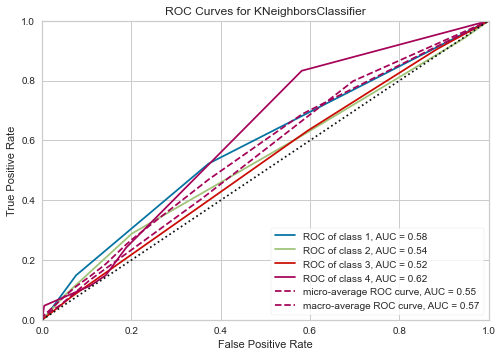

In [55]:
try:
    ROC_curve_plot(untuned_KNN,X_train,y_train,X_test,y_test)
except:
    print()


In [64]:
def best_k_value(X_train, y_train, X_test, y_test, min_k=1, max_k=35):
    b_k = 0
    b_sc = 0.0
    for k in range (min_k, max_k+1, 2):
        KNN_model = KNeighborsClassifier(n_neighbors = k)
        KNN_model.fit(X_train, y_train)
        preds = KNN_model.predict(X_test)
        f1 = metrics.f1_score (y_test, preds, average='micro')
        if f1 > b_sc:
            b_k = k
            b_sc = f1
    print ("Best k:",b_k)
    print ("Best F1-Score:",b_sc)

In [65]:
best_k_value(scaled_train, y_train, scaled_test, y_test)

Best k: 31
Best F1-Score: 0.5600068481424414


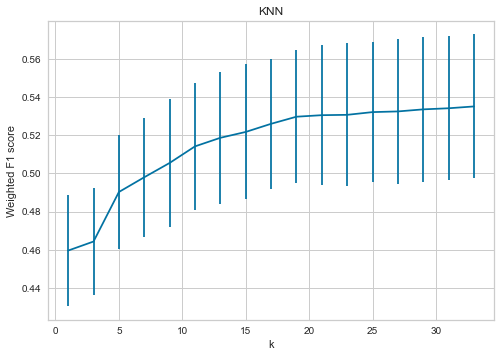

In [58]:
kf = KFold(n_splits=5)
mean_knn=[]; std_knn=[]
krange=range(1,35,2)
for k in krange:
   model = KNeighborsClassifier(n_neighbors=k,weights='uniform')
   knn_values=[]
   for train, test in kf.split(scaled_X):
       model.fit(scaled_X[train], y[train])
       ypred = model.predict(scaled_X[test])
       knn_values.append(metrics.f1_score(y[test],ypred,average='weighted'))
   mean_knn.append(np.array(knn_values).mean())
   std_knn.append(np.array(knn_values).std())
plt.errorbar(krange,mean_knn,yerr=std_knn)
plt.xlabel('k'); plt.ylabel('Weighted F1 score')
plt.title('KNN')
plt.show()


In [59]:
tuned_KNN = KNeighborsClassifier(n_neighbors=31)
tuned_KNN.fit(scaled_train, y_train)
y_pred = tuned_KNN.predict(scaled_test)

In [60]:
print('Weighted F1 score:',metrics.f1_score(y_test, y_pred,average='weighted'))
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

Weighted F1 score: 0.5638515056392894
[[2091  528  328   48]
 [ 631 1324  816  133]
 [ 345  875 1336  360]
 [ 106  308  662 1791]]
              precision    recall  f1-score   support

           1       0.66      0.70      0.68      2995
           2       0.44      0.46      0.45      2904
           3       0.43      0.46      0.44      2916
           4       0.77      0.62      0.69      2867

    accuracy                           0.56     11682
   macro avg       0.57      0.56      0.56     11682
weighted avg       0.57      0.56      0.56     11682



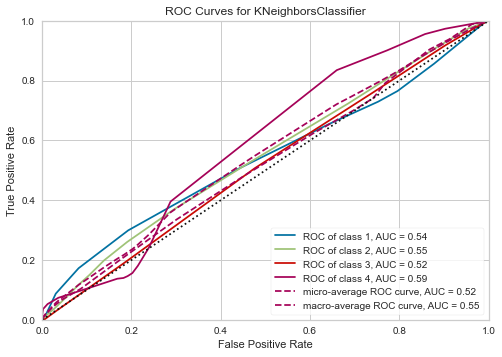

In [61]:
try:
    ROC_curve_plot(tuned_KNN,X_train,y_train,X_test,y_test)
except:
    print()

BAGGING CLASSIFIER

In [69]:
#Bagging classifier
untuned_bc = BaggingClassifier(DecisionTreeClassifier(criterion='entropy', max_depth=5), n_estimators=20)

In [70]:
untuned_bc.fit(X_train, y_train)
y_pred = untuned_bc.predict(X_test)
print('Weighted F1 score:',metrics.f1_score(y_test, y_pred,average='weighted'))
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

Weighted F1 score: 0.6257423806475516
[[2166  628  166   35]
 [ 463 1672  650  119]
 [ 190  974 1300  452]
 [  47  174  492 2154]]
              precision    recall  f1-score   support

           1       0.76      0.72      0.74      2995
           2       0.48      0.58      0.53      2904
           3       0.50      0.45      0.47      2916
           4       0.78      0.75      0.77      2867

    accuracy                           0.62     11682
   macro avg       0.63      0.62      0.63     11682
weighted avg       0.63      0.62      0.63     11682



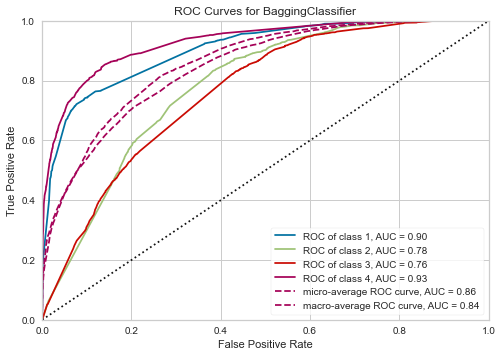

In [79]:
try:
    ROC_curve_plot(untuned_bc,X_train,y_train,X_test,y_test)
except:
    print()

RANDOM FOREST CLASSIFIER

In [80]:
# untuned Random Forest Classifier
untuned_forest = RandomForestClassifier(n_estimators=100, max_depth=6)
untuned_forest.fit(X_train, y_train)
y_pred = untuned_forest.predict(X_test)
print('Weighted F1 score:',metrics.f1_score(y_test, y_pred,average='weighted'))
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

Weighted F1 score: 0.6125870928250092
[[2263  511  135   86]
 [ 740 1424  541  199]
 [ 277  818 1328  493]
 [  56  125  493 2193]]
              precision    recall  f1-score   support

           1       0.68      0.76      0.71      2995
           2       0.49      0.49      0.49      2904
           3       0.53      0.46      0.49      2916
           4       0.74      0.76      0.75      2867

    accuracy                           0.62     11682
   macro avg       0.61      0.62      0.61     11682
weighted avg       0.61      0.62      0.61     11682



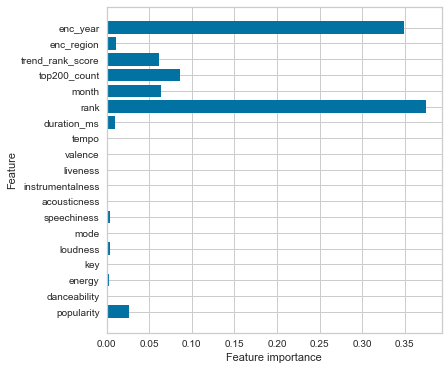

In [81]:
feature_importance_plot(untuned_forest)

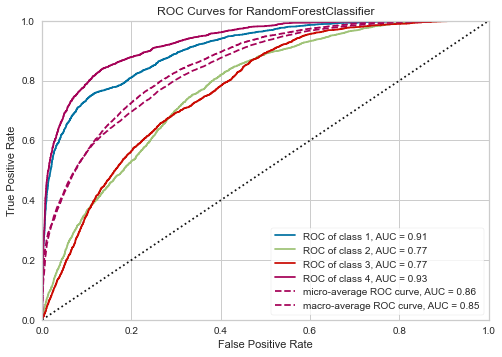

In [82]:
try:
    ROC_curve_plot(untuned_forest,X_train,y_train,X_test,y_test)
except:
    print()

In [84]:
# random forest gridsearch
RF = RandomForestClassifier()
RF_mean = np.mean(cross_val_score(RF, X_train, y_train, cv=3))
print(f"Mean cross validation score: {RF_mean :.2%}")

Mean cross validation score: 67.26%


In [86]:
RF_grid_parameters = {'min_samples_leaf' : [3,6],'min_samples_split' : [5,10],'criterion' : ['gini', 'entropy'],'n_estimators' : [10,30,100],'max_depth' : [None, 2,6,10]}

In [87]:
RF_GS = GridSearchCV(RF, RF_grid_parameters, cv=3)
RF_GS.fit(X_train, y_train)
print("Optimal Parameters:", RF_GS.best_params_)
print("Testing Accuracy",RF_GS.best_score_)

Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}
Testing Accuracy 0.6766399143927234


In [92]:
tuned_RF = RandomForestClassifier (n_estimators=100, max_depth=None, criterion = 'entropy', min_samples_leaf=3,min_samples_split=10)
tuned_RF.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', min_samples_leaf=3,
                       min_samples_split=10)

In [93]:
y_pred = tuned_RF.predict(X_test)
print('Weighted F1 score:',metrics.f1_score(y_test, y_pred,average='weighted'))
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

Weighted F1 score: 0.6912559559444817
[[2331  523  107   34]
 [ 405 1777  610  112]
 [ 142  637 1698  439]
 [  24   65  520 2258]]
              precision    recall  f1-score   support

           1       0.80      0.78      0.79      2995
           2       0.59      0.61      0.60      2904
           3       0.58      0.58      0.58      2916
           4       0.79      0.79      0.79      2867

    accuracy                           0.69     11682
   macro avg       0.69      0.69      0.69     11682
weighted avg       0.69      0.69      0.69     11682



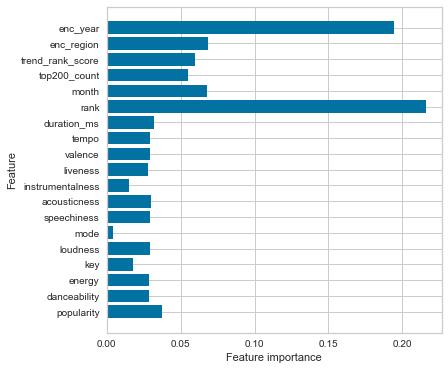

In [94]:
feature_importance_plot(tuned_RF)

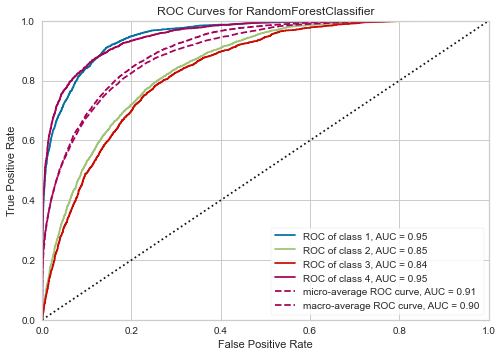

In [95]:
try:
    ROC_curve_plot(tuned_RF,X_train,y_train,X_test,y_test)
except:
    print()

MULTI LAYER PERCEPTRON

In [62]:
#Multilayer perceptron
MLP_parameters = {"alpha": [0.1, 0.01, 0.0001],"solver" : ["lbfgs","adam","sgd"],"hidden_layer_sizes": [(10,10,10),(100,100,100),(100,100)],"activation": ["relu","logistic"]}

In [ ]:
MLP = MLPClassifier(random_state = 0) 
MLP_GS = GridSearchCV(MLP, MLP_parameters, cv = 5, n_jobs = -1,verbose = 2) 
MLP_GS.fit(scaled_train, y_train) 

In [64]:
print(MLP_GS.best_params_)

{'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 100, 100), 'solver': 'adam'}


In [65]:
MLP_TUNED = MLP_GS.best_estimator_
MLP_TUNED.fit(scaled_train, y_train)

MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 100, 100),
              random_state=0)

In [66]:
kf5 = KFold(shuffle=True, n_splits=5) 
kfold = cross_val_score(MLP_TUNED, scaled_test, y_test, cv=kf5, scoring= 'f1_weighted')
print("f1_weigted Results from K-fold CV ",kfold)
print("f1_weigted Results Mean from K-fold CV: ",kfold.mean())

f1_weigted Results from K-fold CV  [0.61666292 0.64982403 0.61536031 0.61609425 0.6202615 ]
f1_weigted Results Mean from K-fold CV:  0.6236406008418839


In [67]:
y_pred = MLP_TUNED.predict(scaled_test)
print("f1_weighted:",metrics.f1_score(y_test, y_pred,average='weighted'))
print("accuracy:",metrics.accuracy_score(y_test,y_pred))
print(metrics.confusion_matrix(y_test,y_pred))
print(metrics.classification_report(y_test,y_pred))

f1_weighted: 0.7121042207299716
accuracy: 0.7122068139017291
[[2456  448   79   12]
 [ 366 1859  624   55]
 [ 100  670 1648  498]
 [   5   61  444 2357]]
              precision    recall  f1-score   support

           1       0.84      0.82      0.83      2995
           2       0.61      0.64      0.63      2904
           3       0.59      0.57      0.58      2916
           4       0.81      0.82      0.81      2867

    accuracy                           0.71     11682
   macro avg       0.71      0.71      0.71     11682
weighted avg       0.71      0.71      0.71     11682



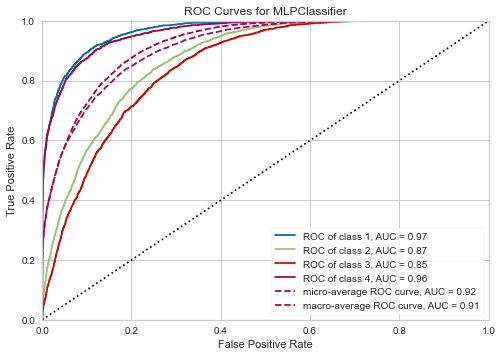

In [96]:
try:
    ROC_curve_plot(MLP_TUNED, scaled_train, y_train, scaled_test, y_test)
except:
    print()

In [19]:
#hidden_layer_range = [5,10,25,50,75,100]
hidden_layer_range=[(10,10,10),(100,100,100),(100,100)]
mean_error=[]; std_error=[]
for n in hidden_layer_range:
    model = MLPClassifier(hidden_layer_sizes=(n), max_iter=300)
    scores = cross_val_score(model, scaled_X, y, cv=5, scoring='f1_weighted')
    print(scores)
    mean_error.append(np.array(scores).mean())
    std_error.append(np.array(scores).std())

[0.52726792 0.60577747 0.46602285 0.45281605 0.30114466]
[0.47817718 0.56372065 0.44678353 0.37497186 0.36879722]


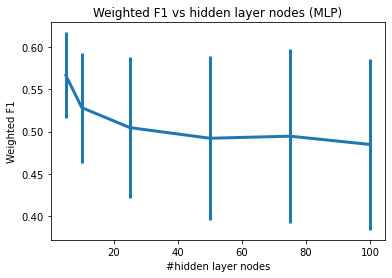

In [11]:
plt.errorbar(hidden_layer_range,mean_error,yerr=std_error,linewidth=3)
plt.xlabel('#hidden layer nodes'); plt.ylabel('Weighted F1')
plt.title('Weighted F1 vs hidden layer nodes (MLP)')
plt.show()

In [12]:
mean_error_c=[]; std_error_c=[]
C_range = [1,5,10,100,1000]
for Ci in C_range:
    model = MLPClassifier(hidden_layer_sizes=(5), alpha = 1.0/Ci)
    scores = cross_val_score(model, scaled_X, y, cv=5, scoring='f1_weighted')
    mean_error_c.append(np.array(scores).mean())
    std_error_c.append(np.array(scores).std())


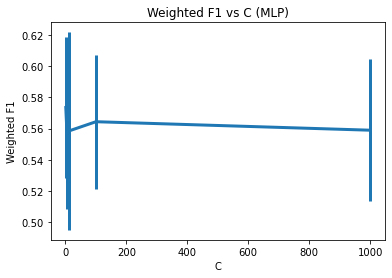

In [14]:
plt.errorbar(C_range,mean_error_c,yerr=std_error_c,linewidth=3)
plt.xlabel('C'); plt.ylabel('Weighted F1')
plt.title('Weighted F1 vs C (MLP)')
plt.show()

In [17]:
model_MLP = MLPClassifier(hidden_layer_sizes=(5), alpha=1.0/100).fit(scaled_train, y_train)
y_pred = model_MLP.predict(scaled_test)

In [18]:
print("f1_weighted:",metrics.f1_score(y_test, y_pred,average='weighted'))
print("accuracy:",metrics.accuracy_score(y_test,y_pred))
print(metrics.classification_report(y_test,y_pred))

f1_weighted: 0.6160297092558483
accuracy: 0.6152199965759287
              precision    recall  f1-score   support

           1       0.77      0.71      0.74      2995
           2       0.51      0.53      0.52      2904
           3       0.46      0.45      0.45      2916
           4       0.73      0.77      0.75      2867

    accuracy                           0.62     11682
   macro avg       0.62      0.62      0.62     11682
weighted avg       0.62      0.62      0.62     11682



REDUCED FEATURE SET

In [98]:
#using the more importantfeatures - remove mode, key, instrumentalness
X = df[['enc_year','enc_region','trend_rank_score','top200_count','month','rank','popularity', 'duration_ms','valence',
        'danceability','tempo', 'liveness', 'acousticness', 'speechiness','loudness','energy']]

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size=0.2)

In [100]:
#untuned decision tree - reduced features
untuned_dt_rf = DecisionTreeClassifier(criterion='entropy', random_state=42)
untuned_dt_rf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [101]:
y_pred = untuned_dt_rf.predict(X_test)
print('Weighted F1 score:',metrics.f1_score(y_test, y_pred,average='weighted'))
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

Weighted F1 score: 0.6403213259516223
[[2246  566  156   27]
 [ 453 1578  746  127]
 [ 145  717 1498  556]
 [  17  128  582 2140]]
              precision    recall  f1-score   support

           1       0.79      0.75      0.77      2995
           2       0.53      0.54      0.54      2904
           3       0.50      0.51      0.51      2916
           4       0.75      0.75      0.75      2867

    accuracy                           0.64     11682
   macro avg       0.64      0.64      0.64     11682
weighted avg       0.64      0.64      0.64     11682



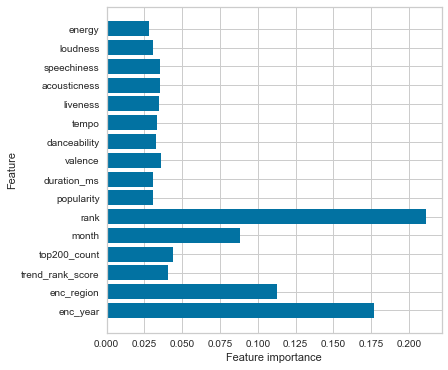

In [102]:
feature_importance_plot(untuned_dt_rf)

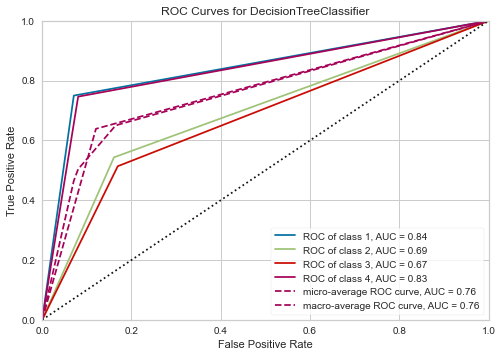

In [103]:
try:
    plot_ROC_curve(untuned_dt_rf,X_train,y_train,X_test,y_test)
except:
    print()

In [104]:
# untuned BaggingClassifier with reduced features
untuned_bc_rf = BaggingClassifier(DecisionTreeClassifier(criterion='entropy', max_depth=5), n_estimators=20)

In [106]:
untuned_bc_rf.fit(X_train, y_train)
y_pred = untuned_bc_rf.predict(X_test)
print('Weighted F1 score:',metrics.f1_score(y_test, y_pred,average='weighted'))
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

Weighted F1 score: 0.6264101434837185
[[2153  624  165   53]
 [ 447 1645  648  164]
 [ 181  940 1313  482]
 [  36  135  497 2199]]
              precision    recall  f1-score   support

           1       0.76      0.72      0.74      2995
           2       0.49      0.57      0.53      2904
           3       0.50      0.45      0.47      2916
           4       0.76      0.77      0.76      2867

    accuracy                           0.63     11682
   macro avg       0.63      0.63      0.63     11682
weighted avg       0.63      0.63      0.63     11682



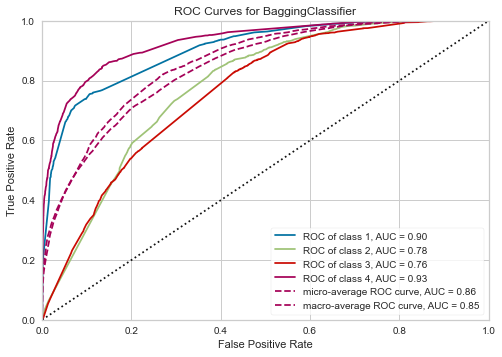

In [108]:
try:
    plot_ROC_curve(untuned_bc_rf,X_train,y_train,X_test,y_test)
except:
    print()

In [109]:
#untuned random forest with reduced features
untuned_forest_rf = RandomForestClassifier(n_estimators=100, max_depth=6)
untuned_forest_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=6)

In [110]:
y_pred = untuned_forest_rf.predict(X_test)
print('Weighted F1 score:',metrics.f1_score(y_test, y_pred,average='weighted'))
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

Weighted F1 score: 0.6129891025783085
[[2262  502  153   78]
 [ 712 1402  594  196]
 [ 277  796 1353  490]
 [  56  116  504 2191]]
              precision    recall  f1-score   support

           1       0.68      0.76      0.72      2995
           2       0.50      0.48      0.49      2904
           3       0.52      0.46      0.49      2916
           4       0.74      0.76      0.75      2867

    accuracy                           0.62     11682
   macro avg       0.61      0.62      0.61     11682
weighted avg       0.61      0.62      0.61     11682



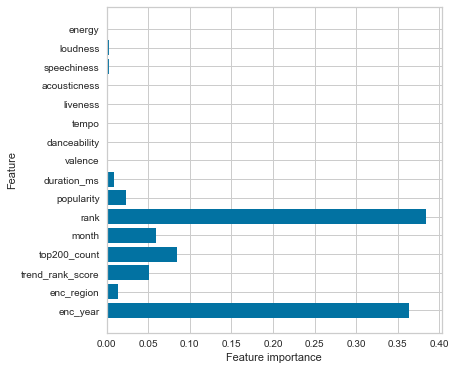

In [111]:
feature_importance_plot(untuned_forest_rf)

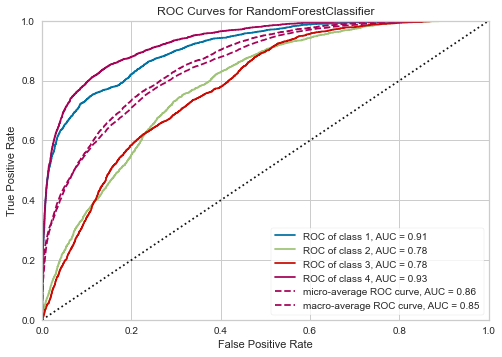

In [112]:
try:
    plot_ROC_curve(untuned_forest_rf,X_train,y_train,X_test,y_test)
except:
    print()

In [118]:
dt = DecisionTreeClassifier()
cv_dt = cross_val_score(dt, X_train, y_train, cv=3) 
dt_mean = np.mean(cv_dt)
print("Cross Validation Mean Score: ",dt_mean)

Cross Validation Mean Score:  0.6298769395398609


In [119]:
parameters_dt = {'min_samples_leaf': [1, 2, 3, 4, 5, 6],'criterion': ['gini', 'entropy'],'min_samples_split': [2, 5, 10],'max_depth': [None, 2, 3, 4, 5, 6]}

In [120]:
dt_GS = GridSearchCV(dt, parameters_dt, cv=3, return_train_score=True)
dt_GS.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True)

In [121]:
dt_GS.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 6,
 'min_samples_split': 2}

In [122]:
tuned_td_rf = DecisionTreeClassifier(max_depth=None, min_samples_leaf = 6,criterion='gini', min_samples_split = 2)
tuned_td_rf.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=6)

In [123]:
y_pred = tuned_td_rf.predict(X_test)
print('Weighted F1 score:',metrics.f1_score(y_test, y_pred,average='weighted'))
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

Weighted F1 score: 0.6669351659358523
[[2350  478  149   18]
 [ 448 1691  657  108]
 [ 116  737 1610  453]
 [  17  129  606 2115]]
              precision    recall  f1-score   support

           1       0.80      0.78      0.79      2995
           2       0.56      0.58      0.57      2904
           3       0.53      0.55      0.54      2916
           4       0.79      0.74      0.76      2867

    accuracy                           0.66     11682
   macro avg       0.67      0.66      0.67     11682
weighted avg       0.67      0.66      0.67     11682



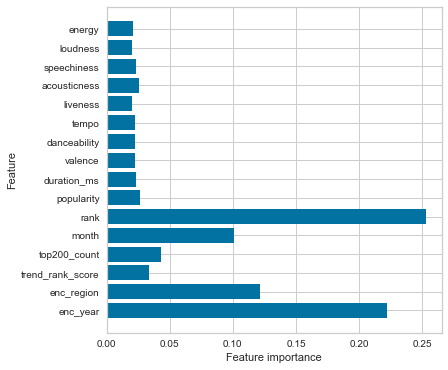

In [124]:
feature_importance_plot(tuned_td_rf)

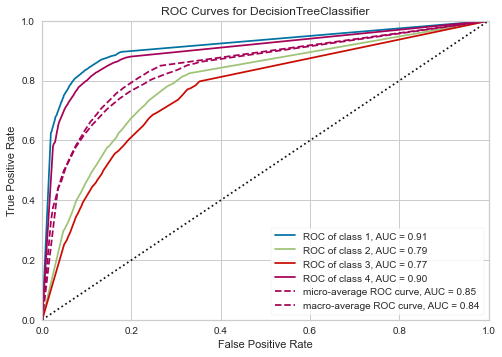

In [126]:
try:
    plot_ROC_curve(tuned_td_rf,X_train,y_train,X_test,y_test)
except:
    print()

In [127]:
rf = RandomForestClassifier()
cv_rf_mean = np.mean(cross_val_score(rf, X_train, y_train, cv=3))
print("Mean Cross Validation Score",cv_rf_mean)

Mean Cross Validation Score 0.685008025682183


In [128]:
parameters_rf = {'min_samples_leaf' : [3,6],'min_samples_split' : [5,10],'criterion' : ['gini', 'entropy'],'max_depth' : [None, 2,6,10],'n_estimators' : [10,30,100]}

In [129]:
rf_GS = GridSearchCV(rf, parameters_rf, cv=3)
rf_GS.fit(X_train, y_train)
print("Test Accuracy:", rf_GS.best_score_)
print("Optimal Params:",rf_GS.best_params_)

Test Accuracy: 0.6884751203852327
Optimal Params: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}


In [131]:
tuned_forest_rf = RandomForestClassifier(criterion= 'entropy', max_depth= None, min_samples_leaf= 3, min_samples_split= 10, n_estimators= 100)
tuned_forest_rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', min_samples_leaf=3,
                       min_samples_split=10)

In [132]:
y_pred = tuned_forest_rf.predict(X_test)
print('Weighted F1 score:',metrics.f1_score(y_test, y_pred,average='weighted'))
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

Weighted F1 score: 0.700810116995417
[[2363  507   90   35]
 [ 403 1818  587   96]
 [ 131  629 1738  418]
 [  23   70  519 2255]]
              precision    recall  f1-score   support

           1       0.81      0.79      0.80      2995
           2       0.60      0.63      0.61      2904
           3       0.59      0.60      0.59      2916
           4       0.80      0.79      0.80      2867

    accuracy                           0.70     11682
   macro avg       0.70      0.70      0.70     11682
weighted avg       0.70      0.70      0.70     11682



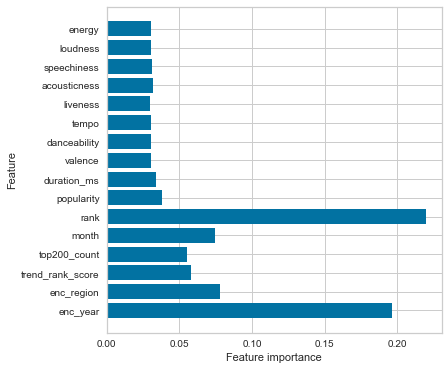

In [133]:
feature_importance_plot(tuned_forest_rf)